# Notebook 02: Feature Selection with Recursive Feature Elimination

This notebook focuses on reducing model complexity and enhancing interpretability by applying recursive feature elimination (RFE) to identify the most impactful features. My goal is to maintain predictive accuracy while using a smaller subset of features.

I also fine-tune hyperparameters using Optuna to optimize model performance.

# Imports:

In [120]:
# Standard library imports
import math
import random
from datetime import date
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from scipy import stats

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import (MinMaxScaler, RobustScaler, FunctionTransformer, 
                                   OneHotEncoder, TargetEncoder, StandardScaler)


from sklearn.model_selection import TimeSeriesSplit

# Feature selection
from sklearn.feature_selection import RFE, RFECV

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import optuna

# MLforecast related imports
from mlforecast import MLForecast

from mlforecast.target_transforms import Differences, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog

# Other forecasting utilities
from window_ops.rolling import rolling_mean, rolling_std

# Performance optimization
from numba import njit
from functools import partial

# Suppress warnings
warnings.filterwarnings('ignore')

# Local imports
from ml_forecast_evaluator import MLForecast_Evaluator

# Data loading:

In [121]:
transf_data = pd.read_pickle('./data/transformed_full_features_data_157f_logdiff.pkl')

train_index = sorted(list(transf_data["ds"].unique()))[:-2]
valid_index = [sorted(list(transf_data["ds"].unique()))[-2]]
test_index = [sorted(list(transf_data["ds"].unique()))[-1]]

train = transf_data.loc[transf_data['ds'].isin(train_index)]
valid = transf_data.loc[transf_data['ds'].isin(valid_index)]
test = transf_data.loc[transf_data['ds'].isin(test_index)]

# Recursive feature selection

## Models

In [122]:
# Define models with built-in feature selection and regularization

xgb = XGBRegressor(
    n_estimators=100,       # Number of trees to grow
    random_state=42
)

cb = CatBoostRegressor(
    iterations=100,        # Number of trees to grow
    random_state=42,        # Random seed for reproducibility
    silent=True            # Suppress CatBoost iteration info
)

models = [xgb, cb]

## Feature selection with cross validation using TimeSeriesSplit

In [123]:
full_train = pd.concat([train, valid]).dropna().reset_index(drop=True)

In [124]:
def custom_time_series_split(df, n_splits=3, test_size=1):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    
    splits = []
    
    for unique_id in df['unique_id'].unique():
        id_data = df[df['unique_id'] == unique_id]
        id_splits = list(tscv.split(id_data))
        
        if not splits:
            splits = [([],[]) for _ in range(n_splits)]
        
        for i, (train_idx, test_idx) in enumerate(id_splits):
            splits[i][0].extend(id_data.index[train_idx])
            splits[i][1].extend(id_data.index[test_idx])
    
    # Convert lists to numpy arrays
    splits = [(np.array(train), np.array(test)) for train, test in splits]
    
    return splits

In [125]:
splits = custom_time_series_split(full_train)

In [126]:
print("Train split shape:", splits[0][0].shape)
print("Test split shape:", splits[0][1].shape)

Train split shape: (10650,)
Test split shape: (426,)


In [127]:
X = full_train.drop(['unique_id', 'ds', 'y'], axis=1)
y = full_train['y']

### CatBoost

In [128]:
# Set up RFECV
rfecv = RFECV(
    estimator=cb,
    step=1,
    cv=splits,
    scoring='neg_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1
)

rfecv.fit(X, y)

RFECV(cv=[(array([    0,     7,    14, ..., 11453, 11465, 11477]),
           array([  175,   176,   177,   178,   179,   180,   181,   339,   340,
         341,   342,   343,   344,   576,   577,   578,   579,   580,
         581,   582,   583,   584,   869,   870,   871,   872,   873,
         874,   875,   876,   877,   878,   879,  1066,  1067,  1068,
        1069,  1070,  1071,  1072,  1430,  1431,  1432,  1433,  1434,
        1435,  1436,  1437,  1438,  1439,  1440,  1441,  1442,  1443,
        1658,  1659,  1660,  1661,  1662,  1663,  1664,  1665,  2074,
        2075,  2076,  20...
       11880, 11881, 11882, 11883, 11884, 11885, 11886, 11887, 11888,
       11889, 11890, 11891, 11892, 11893, 11894, 11895, 11896, 11897,
       11898, 11899, 11900, 11901, 11902, 11903, 11904, 11905, 11906,
       11907, 11908, 11909, 11910, 11911, 11912, 11913, 11914, 11915,
       11916, 11917, 11918, 11919, 11920, 11921, 11922, 11923, 11924,
       11925, 11926, 11927]))],
      estimator=<catboost.core.CatBoostRegressor object at 0x7dbaa973b3b0>,
      n_jobs=-1, scoring='neg_mean_squared_error')

In [129]:
# Get selected features
selected_features_cb = X.columns[rfecv.support_].tolist()

print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected features:")
print(len(selected_features_cb))
print(selected_features_cb)

Optimal number of features: 18
Selected features:
18
['monthly_average_price', 'year', 'quarter', 'month_sin', 'month_cos', 'item_id_city_id_y_max_lag1', 'item_id_city_id_y_max_lag2', 'item_id_city_id_y_min_lag1', 'shop_id_item_category_id_y_min_lag1', 'item_id_city_id_revenue_min_lag1', 'item_id_around_Xmas_revenue_mean', 'item_id_month_revenue_mean', 'item_category_id_month_revenue_mean', 'ytd_sales', 'quarterly_sales', 'price_change', 'expanding_mean_lag1', 'exponentially_weighted_mean_lag1_alpha0.5']


Text(0.5, 1.0, 'Number of Features vs Cross Validation Score')

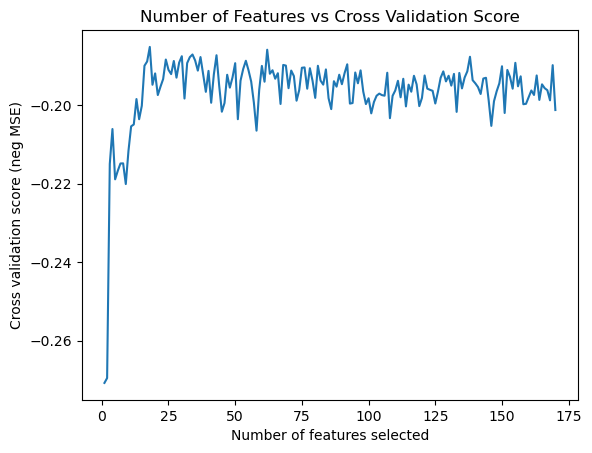

In [130]:
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg MSE)")
plt.title("Number of Features vs Cross Validation Score")

In [131]:
#Feature importances
feat_imp_cb = pd.Series(rfecv.estimator_.feature_importances_, index=X.columns[rfecv.support_].tolist()).sort_values(ascending=False)

In [154]:
feat_imp_cb

exponentially_weighted_mean_lag1_alpha0.5    13.154754
quarterly_sales                              10.652604
ytd_sales                                    10.382304
item_id_city_id_y_min_lag1                    6.705091
item_id_city_id_y_max_lag1                    5.814391
month_cos                                     5.472188
item_id_month_revenue_mean                    5.462296
month_sin                                     5.219033
quarter                                       5.032029
price_change                                  4.794989
year                                          4.074639
expanding_mean_lag1                           3.863682
item_category_id_month_revenue_mean           3.805981
item_id_city_id_revenue_min_lag1              3.742129
item_id_city_id_y_max_lag2                    3.279534
shop_id_item_category_id_y_min_lag1           3.254162
monthly_average_price                         2.705862
item_id_around_Xmas_revenue_mean              2.584331
dtype: flo

In [132]:
#Select those with feature importance > 0
selected_features_cb = feat_imp_cb[feat_imp_cb > 0].index.tolist()
print(len(selected_features_cb))
print(selected_features_cb)

18
['exponentially_weighted_mean_lag1_alpha0.5', 'quarterly_sales', 'ytd_sales', 'item_id_city_id_y_min_lag1', 'item_id_city_id_y_max_lag1', 'month_cos', 'item_id_month_revenue_mean', 'month_sin', 'quarter', 'price_change', 'year', 'expanding_mean_lag1', 'item_category_id_month_revenue_mean', 'item_id_city_id_revenue_min_lag1', 'item_id_city_id_y_max_lag2', 'shop_id_item_category_id_y_min_lag1', 'monthly_average_price', 'item_id_around_Xmas_revenue_mean']


### XGBoost

In [133]:
# Set up RFECV
rfecv = RFECV(
    estimator=xgb,
    step=1,
    cv=splits,
    scoring='neg_mean_squared_error',
    min_features_to_select=1,
    n_jobs=-1
)

rfecv.fit(X, y)

RFECV(cv=[(array([    0,     7,    14, ..., 11453, 11465, 11477]),
           array([  175,   176,   177,   178,   179,   180,   181,   339,   340,
         341,   342,   343,   344,   576,   577,   578,   579,   580,
         581,   582,   583,   584,   869,   870,   871,   872,   873,
         874,   875,   876,   877,   878,   879,  1066,  1067,  1068,
        1069,  1070,  1071,  1072,  1430,  1431,  1432,  1433,  1434,
        1435,  1436,  1437,  1438,  1439,  1440,  1441,  1442,  1443,
        1658,  1659,  1660,  1661,  1662,  1663,  1664,  1665,  2074,
        2075,  2076,  20...
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_threshold=None, max_cat_to_onehot=None,
                             max_delta_step=None, max_depth=None,
                             max_leaves=None, min_child_weight=None,
                             missing=nan, monotone_constraints=None,
                             multi_strategy=None, n_estimators=100, n_jobs=None,
                             num_parallel_tree=None, random_state=42, ...),
      n_jobs=-1, scoring='neg_mean_squared_error')

In [134]:
# Get selected features
selected_features_xgb = X.columns[rfecv.support_].tolist()

print("Optimal number of features: %d" % rfecv.n_features_)
print("Selected features:")
print(len(selected_features_xgb))
print(selected_features_xgb)

Optimal number of features: 109
Selected features:
109
['year', 'quarter', 'around_Xmas', 'month_sin', 'month_cos', 'item_category_id_y_sum_lag1', 'item_category_id_y_sum_lag2', 'item_category_id_y_max_lag2', 'item_id_city_id_y_sum_lag1', 'item_id_city_id_y_sum_lag2', 'item_id_city_id_y_max_lag1', 'item_id_city_id_y_max_lag2', 'item_id_city_id_y_min_lag1', 'item_id_city_id_y_min_lag2', 'shop_id_item_category_id_y_max_lag1', 'shop_id_item_category_id_y_max_lag2', 'shop_id_item_category_id_y_min_lag1', 'shop_id_item_category_id_y_min_lag2', 'item_category_id_city_id_y_max_lag1', 'item_category_id_city_id_y_min_lag1', 'item_id_revenue_sum_lag2', 'item_id_revenue_max_lag1', 'item_id_revenue_max_lag2', 'item_id_revenue_min_lag1', 'item_id_revenue_min_lag2', 'shop_id_revenue_sum_lag2', 'shop_id_revenue_max_lag1', 'shop_id_revenue_max_lag2', 'item_category_id_revenue_sum_lag1', 'item_category_id_revenue_sum_lag2', 'item_category_id_revenue_max_lag1', 'item_category_id_revenue_max_lag2', 'item

Text(0.5, 1.0, 'Number of Features vs Cross Validation Score')

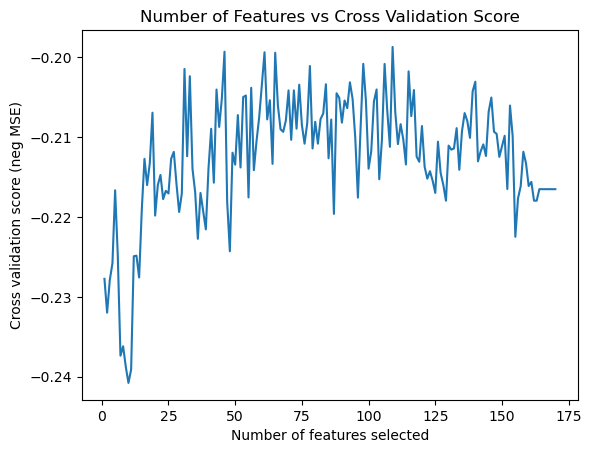

In [135]:
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg MSE)")
plt.title("Number of Features vs Cross Validation Score")

In [136]:
#Feature importances
feat_imp_xgb = pd.Series(rfecv.estimator_.feature_importances_, index=X.columns[rfecv.support_].tolist()).sort_values(ascending=False)
print(feat_imp_xgb)
#Select those with feature importance > 0
selected_features_xgb = feat_imp_xgb[feat_imp_xgb > 0].index.tolist()
print(len(selected_features_xgb))
print(selected_features_xgb)

exponentially_weighted_mean_lag1_alpha0.5    0.138487
item_id_city_id_revenue_min_lag1             0.034864
item_id_city_id_y_max_lag1                   0.024676
item_id_city_id_y_min_lag1                   0.024501
item_category_id_month_revenue_mean          0.021214
                                               ...   
item_id_city_id_revenue_max_lag1             0.003258
rolling_std_lag2_window_size3                0.003239
item_category_id_y_sum_lag1                  0.003213
shop_id_year_revenue_mean                    0.003189
shop_id                                      0.002870
Length: 109, dtype: float32
109
['exponentially_weighted_mean_lag1_alpha0.5', 'item_id_city_id_revenue_min_lag1', 'item_id_city_id_y_max_lag1', 'item_id_city_id_y_min_lag1', 'item_category_id_month_revenue_mean', 'month_cos', 'item_category_id_quarter_revenue_std', 'around_Xmas', 'ytd_sales', 'expanding_mean_lag1', 'item_category_id', 'quarterly_sales', 'item_category_id_quarter_revenue_mean', 'item_cat

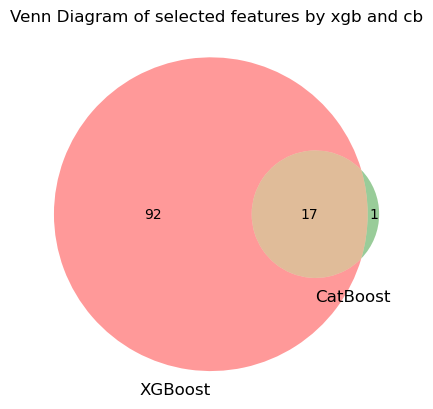

In [150]:
## Intersect selected features

set1 = set(selected_features_xgb)
set2 = set(selected_features_cb)

# Create the Venn Diagram
venn2(subsets = [set1, set2], set_labels = ('XGBoost', 'CatBoost'))
plt.title("Venn Diagram of selected features by xgb and cb")
plt.show()

# Train with CatBoost selected features

## Train, val, test selected

In [249]:
# Restore original scale of the target variable
untransf_data = pd.read_pickle('./data/full_features_data_157f.pkl')

transf_data['y'] = untransf_data['y']

In [250]:
train = transf_data.loc[transf_data['ds'].isin(train_index)]
valid = transf_data.loc[transf_data['ds'].isin(valid_index)]
test = transf_data.loc[transf_data['ds'].isin(test_index)]

In [251]:
train_valid_columns = [col for col in selected_features_cb if col in train.columns] + ['y', 'ds', 'unique_id']
train_selected_cb = train[train_valid_columns]
valid_selected_cb = valid[train_valid_columns]
test_selected_cb = test[train_valid_columns]

In [252]:
future_df_cb = pd.concat([train_selected_cb, valid_selected_cb]).drop('y', axis=1)

In [253]:
print(train_selected_cb.shape)
print(valid_selected_cb.shape)

print(future_df_cb.shape)

(13632, 21)
(426, 21)
(14058, 20)


This should be adapted in case log or log diff data is used

In [254]:
sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=cb,
    freq='M',
    target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],
    num_threads=6
)

In [255]:
fcst.fit(train_selected_cb, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[CatBoostRegressor], freq=M, lag_features=[], date_features=[], num_threads=6)

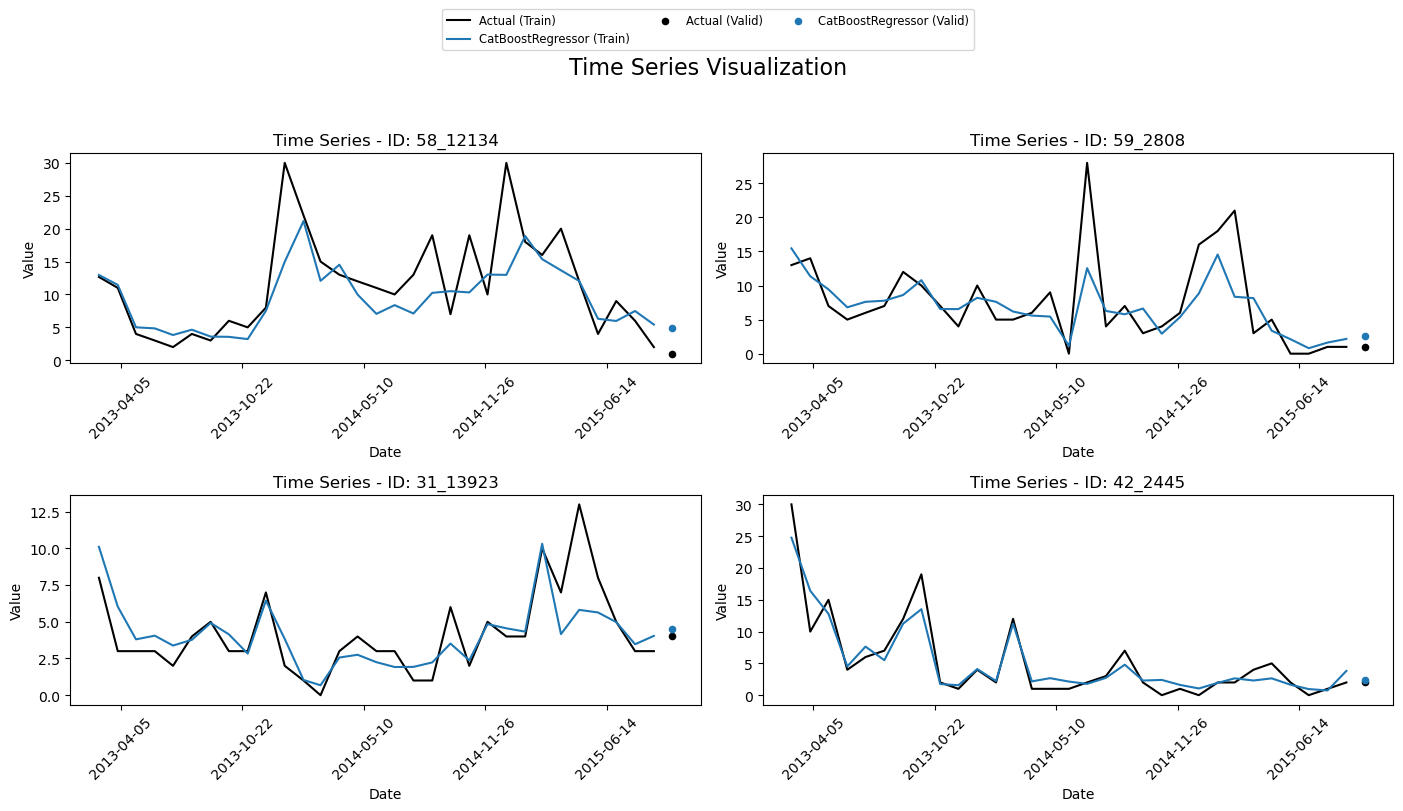

MEAN RMSE_VALID = 2.9223133480670676

Model with lowest RMSE validation is CatBoostRegressor with RMSE = 2.9223133480670676

                   RMSE_train  R2_train  RMSE_valid  R2_valid
CatBoostRegressor    2.615175  0.893978    2.922313  0.843116


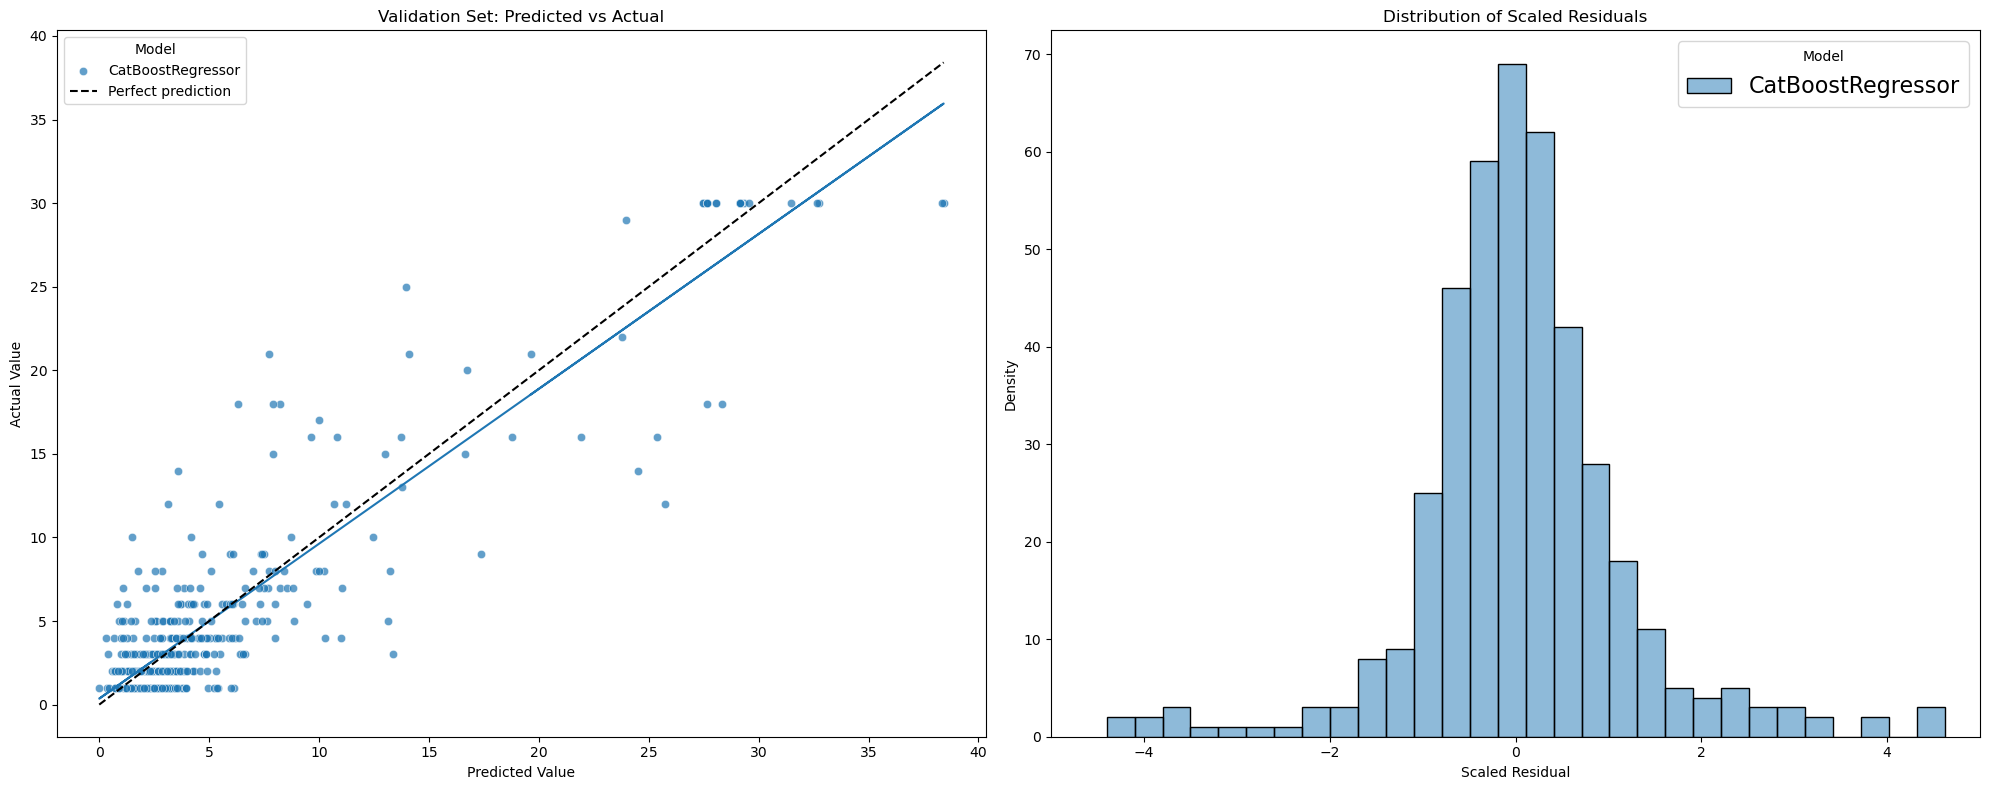

In [256]:
evaluator = MLForecast_Evaluator(fcst, valid_selected_cb, future_df_cb, h=1)

evaluator.plot_time_series(n_samples=4)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Hyperparameter tuning with selected features

## CatBoost

In [257]:
full_train = pd.concat([train_selected_cb, valid_selected_cb])
prep = fcst.preprocess(full_train, dropna=False, static_features=[])

prep_train = prep[prep['ds'].isin(train_index)]
prep_val = prep[prep['ds'].isin(valid_index)]
X_train = prep_train.set_index(['ds', 'unique_id']).dropna().drop('y', axis=1)
y_train = prep_train.set_index(['ds', 'unique_id']).dropna()['y']

X_val = prep_val.set_index(['ds', 'unique_id']).dropna().drop('y', axis=1)
y_val = prep_val.set_index(['ds', 'unique_id']).dropna()['y']

In [258]:
def objective(trial):
    """
    Defines the objective function for hyperparameter optimization using Optuna and CatBoost.

    Args:
        trial: An Optuna trial object used to suggest hyperparameter values.

    Returns:
        float: The root mean squared error (RMSE) of the CatBoost model with the suggested hyperparameters.
    """
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [ ]:
print('Best hyperparameters with CatBoost selected features:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters with CatBoost selected features: {'learning_rate': 0.05741313522223921, 'depth': 4, 'subsample': 0.5577548388323634, 'colsample_bylevel': 0.48786236781327075, 'min_data_in_leaf': 80}
Best RMSE: 0.43275195803704275


# Test tunned Catboost with selected features

In [260]:
tunned_cb = CatBoostRegressor(
    learning_rate=0.05741313522223921,
    depth=4,
    subsample=0.5577548388323634,
    colsample_bylevel=0.48786236781327075,
    min_data_in_leaf=80,
    iterations=1000,
    silent=True,
    random_state=23
)

In [261]:
fcst = MLForecast(
    models=tunned_cb,
    freq='M',
    target_transforms=[GlobalSklearnTransformer(sk_log1p), Differences([1])],
    num_threads=6
)

fcst.fit(train_selected_cb, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

evaluator = MLForecast_Evaluator(fcst, valid_selected_cb, future_df_cb, h=1)
evaluator.calculate_metrics()

MEAN RMSE_VALID = 2.691585485048103

Model with lowest RMSE validation is CatBoostRegressor with RMSE = 2.691585485048103

                   RMSE_train  R2_train  RMSE_valid  R2_valid
CatBoostRegressor    2.895146  0.870063    2.691585  0.866911


,RMSE_train,R2_train,RMSE_valid,R2_valid
CatBoostRegressor,2.895146,0.870063,2.691585,0.866911


# Predicting future values (test) with tunned catboost and:
- Selected features
- All features

## Full features

In [262]:
full_train = pd.concat([train, valid])
future_df_full = test.drop('y', axis=1)

In [263]:
fcst.fit(full_train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[CatBoostRegressor], freq=M, lag_features=[], date_features=[], num_threads=6)

In [264]:
# Predict save second prediction as submission
evaluator_test = MLForecast_Evaluator(fcst, valid, future_df_full, h=1) #Valid df here is not being used

#for model in evaluator.model_columns:
model = 'CatBoostRegressor'
evaluator_test.predict_save_submission(model, test_index=test_index)

Submission file 'submissions/2024-07-29_submission_CatBoostRegressor_mean_valid_RMSE_unknown.csv' has been created successfully.


,unique_id,monthly_sales
0,12_11365,16.459133
1,12_11369,26.926454
2,12_11370,29.389676
3,12_11373,31.211578
4,12_12231,2.745441
...,...,...
421,7_5822,7.227276
422,7_6185,2.251042
423,7_6497,3.768413
424,7_7856,2.684717


## Selected features

In [265]:
full_train = pd.concat([train_selected_cb, valid_selected_cb])
future_df_selected = test_selected_cb.drop('y', axis=1)

In [266]:
fcst.fit(full_train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[CatBoostRegressor], freq=M, lag_features=[], date_features=[], num_threads=6)

In [267]:
# Predict save second prediction as submission
evaluator_test = MLForecast_Evaluator(fcst, valid_selected_cb, future_df_selected, h=1) #Valid df here is not being used

#for model in evaluator.model_columns:
model = 'CatBoostRegressor'
evaluator_test.predict_save_submission(model, test_index=test_index)

Submission file 'submissions/2024-07-29_submission_CatBoostRegressor_mean_valid_RMSE_unknown.csv' has been created successfully.


,unique_id,monthly_sales
0,12_11365,14.841411
1,12_11369,26.300657
2,12_11370,30.782352
3,12_11373,30.794734
4,12_12231,2.713928
...,...,...
421,7_5822,6.175857
422,7_6185,2.425534
423,7_6497,3.259282
424,7_7856,2.631511
